In [210]:
import plotly.express as px
import pandas as pd
import numpy as np

In [211]:
# Assumptions about the space where the collisions will happen.
#
# These are used to bound the rays that are the paths of the hailstones when drawing them.

BOX_MIN = 0
BOX_MAX = 600_000_000_000_000

def float_array(v):
    """Convert a list of ints to a numpy floating vector"""
    return np.array([float(x) for x in v])

In [212]:
class Hail:
    """
    Information about one hailstone: 
        p - The point where it starts at time t=0 
        v - The velocity vector that is the movement at each tick of time.
    """
    def __init__(self, p, v):
        self.p = p
        self.fp = float_array(p)
        self.v = v
        self.fv = float_array(v)

    def __str__(self):
        return repr(self)

    def __repr__(self):
        return "Hail({0}, {1})".format(self.p, self.v)

    def num_ticks(self):
        """How many clock ticks will this hailstone stay within BOX_MIN / BOX_MAX in all dimensions?"""
        def one_axis(pos_and_vel):
            (p, v) = pos_and_vel
            assert BOX_MIN <= p <= BOX_MAX
            if v < 0:
                ticks = (p - BOX_MIN) // (-v)
            else:
                ticks = (BOX_MAX - p) // v
            return ticks 
            
        return min(one_axis(p_and_v) for p_and_v in zip(self.p, self.v))

    def at_time(self, t):
        """Where is this stone at time t?"""
        [x, y, z] = self.p
        [vx, vy, vz] = self.v 
        return [x + vx * t, y + vy * t, z + vz * t]

    def at_time_f(self, t): 
        return self.fp + t * self.fv

    def at_fraction(self, frac):
        t = frac * self.num_ticks()
        return self.at_time_f(t)

    def ticks_at_fraction(self, frac):
        return frac * self.num_ticks()

In [213]:
# The input file consists of lines with the starting position and velocity of a hailstone:
#  '197869613734967, 292946034245705, 309220804687650 @ 150, 5, -8'
#
# Parse them and turn them into a list of pairs of lists:
#
#   ([197869613734967, 292946034245705, 309220804687650], [150, 5, -8]) 
#

def parse_coords(s):
    return [int(x) for x in s.split()]
    
def parse_input_line(line):
    sides = line.replace(",", "").split("@")
    return Hail(parse_coords(sides[0]), parse_coords(sides[1]))
    
def read_input_file():
    with open("input.txt") as f:
        input_text = f.read()
    input_lines = input_text.splitlines()
    hail_lines = input_lines[1:]
    return [parse_input_line(line) for line in hail_lines]

hails = read_input_file() 
hails[:5]

[Hail([197869613734967, 292946034245705, 309220804687650], [150, 5, -8]),
 Hail([344503265587754, 394181872935272, 376338710786779], [-69, 11, -46]),
 Hail([293577250654200, 176398758803665, 272206447651388], [-17, 101, 26]),
 Hail([227838629808858, 367321356713508, 425398385268402], [65, 16, -116]),
 Hail([297081053375721, 388848043410867, 296378505058047], [-18, -39, 33])]

In [214]:
# Turn `hails` into a DataFrame with these columns:
#   id : unique id for each hailstone 
#   x : x coordinate 
#   y : y coordinate 
#   z : z coordinate 
#
# Each hailstone has two entries: the starting point, and its travel as far as 0 or 50_000_000_000_000 on any axis.
#

def make_data_frame(entries): 
    records = [] 
    i = 0
    for hail in entries:
        [x, y, z] = hail.p
        [vx, vy, vz] = hail.v
        ticks = hail.num_ticks()
        records.append(dict(id=i, x=x, y=y, z=z, t=0))
        records.append(dict(id=i, x=(x + vx*ticks), y=(y + vy*ticks), z=(z + vz*ticks), t=ticks))
        i = i + 1
    return pd.DataFrame.from_records(records)

# My browser (Safari) hangs with 200 of them, so just showing 100.
hail = make_data_frame(hails[1:5])
hail

,id,x,y,z,t
0,0,344503265587754,394181872935272,376338710786779,0
1,0,11,449102683391289,146669867061617,4992800950547
2,1,293577250654200,176398758803665,272206447651388,0
3,1,222278031838979,599999999999978,381252311721726,4194071695013
4,2,227838629808858,367321356713508,425398385268402,0
5,2,466208414657508,425996996060868,42,3667227459210
6,3,297081053375721,388848043410867,296378505058047,0
7,3,131469328861935,30022640297664,599999999999988,9200651361877


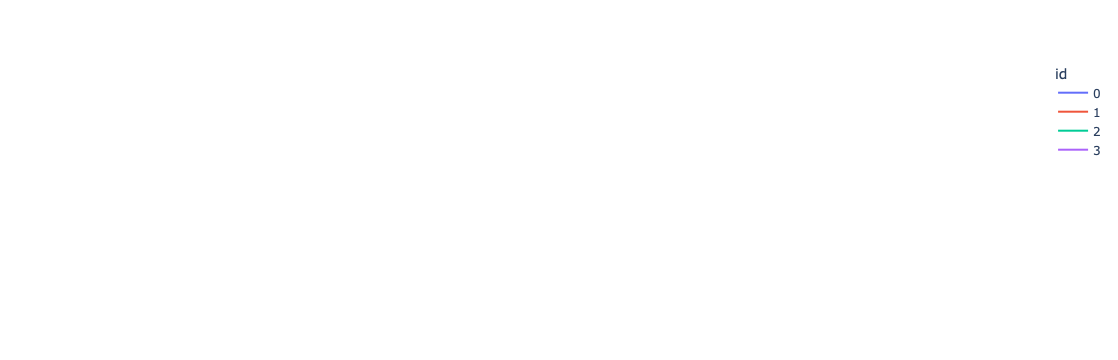

In [215]:
# Choices: scatter_3d, line_3d
fig = px.line_3d(hail, x="x", y="y", z="z", color="id")
fig.show()

In [216]:
def distance_point_to_line(a, b0, b1):
    """Distance from point a to line through (b0, b1)

    https://mathworld.wolfram.com/Point-LineDistance3-Dimensional.html
    """
    return np.linalg.norm(np.cross(a - b0,  a - b1)) / np.linalg.norm(b1 - b0)


def lines_to_data_frame(lines):
    records = []
    for i, line in enumerate(lines):
        for p in line:
            x, y, z = p
            records.append(dict(id=i, x=x, y=y, z=z))
    return pd.DataFrame.from_records(records)

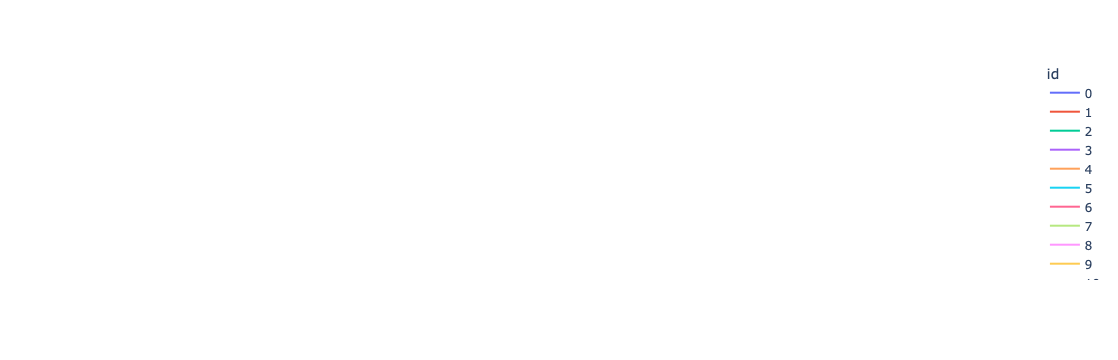

In [217]:
# Let's try drawing all of the lines that start at the start point of 
# hail stone A and go through the various points that hailstone B goes
# through on its path.

def make_line_seq(hailA, hailB):
    """Make a data frame with the lines"""
    [x0, y0, z0] = hailA.p
    max_ticks = hailB.num_ticks()
    return lines_to_data_frame([hailA.p, hailB.at_time_f(t)] for t in range(0, max_ticks, max_ticks // 20))

line_seq = make_line_seq(hails[1], hails[2])
px.line_3d(line_seq, x="x", y="y", z="z", color="id").show()

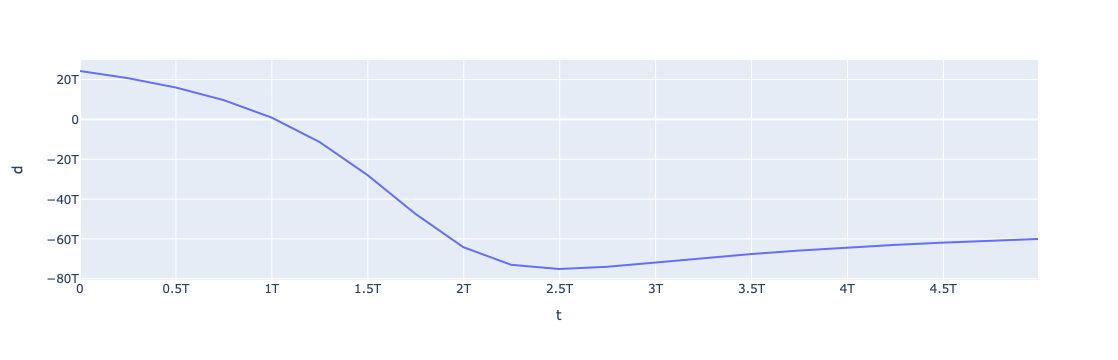

In [218]:
# Given three hail stones, what's the distance from the sequence of lines above to the third line?

def distance_between_two_lines(p1, v1, p2, v2):
    # Original source: https://math.stackexchange.com/questions/2213165/find-shortest-distance-between-lines-in-3d 
    
    # v1, v2 = Direction vector
    # p1, p2 = Point where the line passes through

    # Find the unit vector perpendicular to both lines
    n = np.cross(v1, v2)
    n /= np.linalg.norm(n)

    # Calculate distance
    d = np.dot(n, p1 - p2)

    return d

    
def make_distances(hailA, hailB, hailC):
    """Make a data frame with the lines"""
    p1 = float_array(hailA.fp)
    max_ticks = hailB.num_ticks()
    records = []
    for t in range(0, max_ticks, max_ticks // 20):
        v1 = hailB.at_time_f(t) - p1
        d = distance_between_two_lines(p1, v1, hailC.fp, hailC.fv)
        records.append(dict(t=t, d=d))
    return pd.DataFrame.from_records(records)

distances = make_distances(hails[0], hails[1], hails[2])
px.line(distances, x="t", y="d").show()

In [219]:
def sign(x):
    if x is None:
        return None
    elif x < 0:
        return -1
    elif 0 < x:
        return 1
    else: 
        return 0

def narrow(f, a, b, n): 
    mid = (a + b) / 2.0
    if n == 0:
        return mid 
    else:
        fm = f(mid)
        if fm is None:
            return None
        elif fm < 0:
            return narrow(f, mid, b, n - 1) 
        else:
            return narrow(f, a, mid, n - 1)

def find_zero(f, low, high):
    """Finds x such that f(x) is near zero"""
    prev_x = low 
    prev_s = sign(f(low))
    for i in range(0, 1000):
        x = low + (high - low) * i / 1000.0
        s = sign(f(x))
        if prev_s is not None and s is not None:
            if s != prev_s:
                if prev_s < 0: 
                    return narrow(f, prev_x, x, 100)
                else:
                    return narrow(f, x, prev_x, 100)
        prev_s = s

In [220]:
def distance_to(p0, v0):
    """Returns a function that, given a line, returns the distance to the line (p0, v0)"""
    def f(p1, v1):
        return distance_between_lines(p0, v0, p1, v1)
    return f


def inner(p1, hailB, hailC):
    def f(x):
        p2 = hailB.at_fraction(x)
        return distance_between_two_lines(p1, (p2 - p1), hailC.fp, hailC.fv)
    return f

def outer(hailA, hailB, hailC, hailD):
    def f(x):
        pA = hailA.at_fraction(x)
        fracB = find_zero(inner(pA, hailB, hailC), 0.0, 1.0)
        if fracB is not None:
            pB = hailB.at_fraction(fracB)
            return distance_between_two_lines(pA, pB - pA, hailD.fp, hailD.fv)
    return f

hailA = hails[0]
hailB = hails[1]
hailC = hails[2]
hailD = hails[4]
fracA = find_zero(outer(hailA, hailB, hailC, hailD), 0.0, 1.0)
fracB = find_zero(inner(hailA.at_fraction(fracA), hailB, hailC), 0.0, 1.0)
(fracA, hailA.ticks_at_fraction(fracA), fracB, hailB.ticks_at_fraction(fracB))

(8.598583866909029e-32,
 2.305167901154177e-19,
 0.20436801350395395,
 1020368812083.9434)

In [222]:
sum(hails[0].p)

800036452668322